# Python Stock Screener

> _Creating a Stock Screener for Technical Analysis_

## 0 - Import Libraries

In [1]:
import pandas as pd
import pandas_datareader.data as web
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# plt.style.use('seaborn-whitegrid')
from tqdm import tqdm
from mpl_finance import candlestick_ochl
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
import pylab
from datetime import datetime, timedelta
pylab.rcParams['xtick.major.pad']='10'
pylab.rcParams['ytick.major.pad']='8'

title_dict = {'family': 'Serif','weight': 'bold','size': 22}
axis_dict = {'family': 'Serif','style': 'italic','size': 14}

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/gabrielperezprieto/opt/anaconda3/lib/python3.7/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


## 1 - Get Stock Prices from Yahoo Finance
> _Yahoo! Finance is a media property that is part of Yahoo!'s network. It provides financial news, data and commentary including stock quotes, press releases, financial reports, and original content. It also offers some online tools for personal finance management. [Learn More](https://finance.yahoo.com/)_

> _Remote Data Access with Pandas DataReader [Documentation](https://pandas-datareader.readthedocs.io/en/latest/)_

### 1.1 - Define Function to Get Prices - `DataReader`

In [2]:
def get_prices(ticker_list, start_date, end_date):
    '''
    Get Stock Prices from Yahoo Finance for Specific Time Frame
    Inputs = List of Tickers, Start Date and End Date
    Output = DataFrame
    '''
    # Instantiate DataFrame to house prices
    prices_df = pd.DataFrame()

    # Loop through all companies in the data
    for ticker in tqdm(ticker_list):
        
        # Get prices
        ticker_df = web.DataReader(ticker ,'yahoo', start_date, end_date)

        # Create columns with company's ticker
        ticker_df['ticker'] = ticker

        # Concatenate DataFrame with prices_df
        prices_df = pd.concat([prices_df, ticker_df], axis=0)
    
    # Remove data from index
    prices_df.reset_index(inplace=True)
    
    # Lower columns names
    prices_df.columns = [column.lower() for column in prices_df.columns]

    # Return DataFrame with all companies prices for requested timeframe
    return prices_df

In [3]:
# Get Prices and Save as `prices_df`
prices_df = get_prices(['AAPL'], '2010-01-01', '2021-12-31')

100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


## 2 - Create Metrics for Screener
> _This step calculates a few of the most common technical indicators of a stock._

> _Technical Analysis Library_ [Learn More](https://technical-analysis-library-in-python.readthedocs.io/en/latest/index.html)

### 2.1 - `SMA's` - Simple Moving Averages

In [4]:
for i in [10, 20, 50]: #, 100, 200]:
    prices_df['SMA_' + str(i)] = prices_df['close'].rolling(i).mean()

### 2.2 - `RSI` Relative Strength Index

In [5]:
for i in [7, 14]:
    prices_df['RSI_' + str(i)] = RSIIndicator(prices_df['close'], n=i).rsi()

### 2.3 - `MACD` - Moving Average Convergence / Divergence

In [6]:
prices_df['MACD_line'] = MACD(prices_df['close']).macd()
prices_df['MACD_hist'] = MACD(prices_df['close']).macd_diff()
prices_df['MACD_signal'] = MACD(prices_df['close']).macd_signal()

### 2.4 - `Bollinger Bands`

In [7]:
# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=prices_df['close'], n=20, ndev=2)

# Add Bollinger Bands features
# prices_df['bb_bbm'] = indicator_bb.bollinger_mavg() # This is == SMA_20
prices_df['BBH'] = indicator_bb.bollinger_hband()
prices_df['BBL'] = indicator_bb.bollinger_lband()

# Add Bollinger Band high indicator
prices_df['BBHI'] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
prices_df['BBLI'] = indicator_bb.bollinger_lband_indicator()

## 3 - Define Function to Create a `Stock Screener`

In [8]:
def plot_screener(dataframe, ticker, start, end):
   
    '''
    Plot Stock Screener for the Selected Company
    '''    
    # Get Interval to Plot
    dataframe = dataframe.loc[(dataframe['date'] >= start) & (dataframe['date'] <= end)].copy()
    
    # Set Dates to Numerical
    dataframe['date'] = dataframe['date'].apply(mdates.date2num)
    
    yticks_size = 12
    xticks_size = 12
    
    # Figure Size
    fig = plt.figure(figsize=(14,12))
    
    # Set Main Plot Grid - CandleStick + MA's
    ax1 = plt.subplot2grid((7,4), (1,0), rowspan=4, colspan=4)
    
    # ---------- SMA's ---------- #
    # Plot Moving Averages
    ax1.plot(dataframe['date'], dataframe['SMA_20'], color='navy', label='SMA20', linewidth=1.5)
    ax1.plot(dataframe['date'], dataframe['SMA_50'], color='darkcyan', label='SMA50', linewidth=1.5)
    # CandleStick Prices Plot
    candle_cols = ['date', 'open', 'close', 'high', 'low', 'volume']
    candlestick_ochl(ax1, dataframe[candle_cols].values, width=.6, colorup='#53c156', colordown='#ff1717', alpha=.9)
    
    # Bollinger Bands
    ax1.plot(dataframe['date'], dataframe['BBH'], color='cyan', label='BBH', linewidth=1.5, alpha=.2)
    ax1.plot(dataframe['date'], dataframe['BBL'], color='cyan', label='BBL', linewidth=1.5, alpha=.2)
    ax1.fill_between(dataframe['date'], dataframe['BBH'], dataframe['BBL'], facecolor='cyan', alpha=.1)
      
    # Settings Prices Plot
    plt.ylabel('Stock Price', fontdict=axis_dict)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.legend(loc='upper left', fancybox=True, frameon=True, fontsize=12)
    plt.yticks(size=yticks_size)
    plt.grid(zorder=0)

    # ---------- RSI ---------- #
    # Set RSI Grid
    ax0 = plt.subplot2grid((7,4), (0,0), sharex=ax1, rowspan=1, colspan=4)
    
    # RSI Plot
    ax0.plot(dataframe['date'], dataframe['RSI_14'], linewidth=1.5, color='purple', label='RSI (14)')
    ax0.set_ylim(0,100)
    
    # Create lines for RSI == 30 and RSI == 70
    ax0.axhline(70, color='#ff1717', linestyle='--', linewidth=1)
    ax0.axhline(30, color='#53c156', linestyle='--', linewidth=1)
    ax0.axhline(50, color='#000000', linestyle='--', linewidth=0.5)
    ax0.set_yticks([30,70])
    
    # Fill When RSI > 70 and RSI < 30
    ax0.fill_between(dataframe['date'], dataframe['RSI_14'],
                     70, where=(dataframe['RSI_14'] >= 70), facecolor='#ff1717')
    ax0.fill_between(dataframe['date'], dataframe['RSI_14'],
                     30, where=(dataframe['RSI_14'] <= 30), facecolor='#53c156')

    # RSI Settings
    plt.ylabel('RSI', fontdict=axis_dict)
    plt.title('Stock Screener ' + str(dataframe['ticker'].unique()[0]), pad=10, fontdict=title_dict)
    plt.yticks(size=yticks_size)
    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.legend(loc='upper left', fancybox=True, frameon=True, fontsize=12)
    plt.grid(zorder=0)
               
    # ---------- Volume ---------- #
    # Set Volume Grid
    ax2 = plt.subplot2grid((7,4), (5,0), sharex=ax1, rowspan=1, colspan=4)
    
    # Volume Plot
    ax2.bar(dataframe['date'], dataframe['volume'], alpha=.8, label='Volume')
    
    # Settings Volume Plot
    plt.ylabel('Volume', fontdict=axis_dict)
    plt.xticks(size=xticks_size)
    plt.yticks(size=yticks_size)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.legend(loc='upper left', fancybox=True, frameon=True, fontsize=10)
    plt.grid(zorder=0)
    
    # ---------- MACD ---------- #
    # Set MACD Grid
    ax3 = plt.subplot2grid((7,4), (6,0), sharex=ax1, rowspan=1, colspan=4)   
    ax3.plot(dataframe['date'], dataframe['MACD_line'], linewidth=1.5, color='purple', label='MACD_line')
    c = ['#53c156' if x >= 0 else '#ff1717' for x in dataframe['MACD_hist']]
    ax3.bar(dataframe['date'], dataframe['MACD_hist'], linewidth=1.5, color=c)
    ax3.plot(dataframe['date'], dataframe['MACD_signal'], linewidth=1.5, color='orange', label='MACD_signal')  
    
    # Settings MACD Plot
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(size=xticks_size)
    plt.xlabel('Date', fontdict=axis_dict)
    plt.ylabel('MACD', fontdict=axis_dict)
    plt.yticks(size=yticks_size)
    plt.legend(loc='upper left', fancybox=True, frameon=True, fontsize=10)
    plt.grid(zorder=0)

    plt.tight_layout(pad=5, h_pad=-.1, w_pad=.8)
    
    return plt.show()

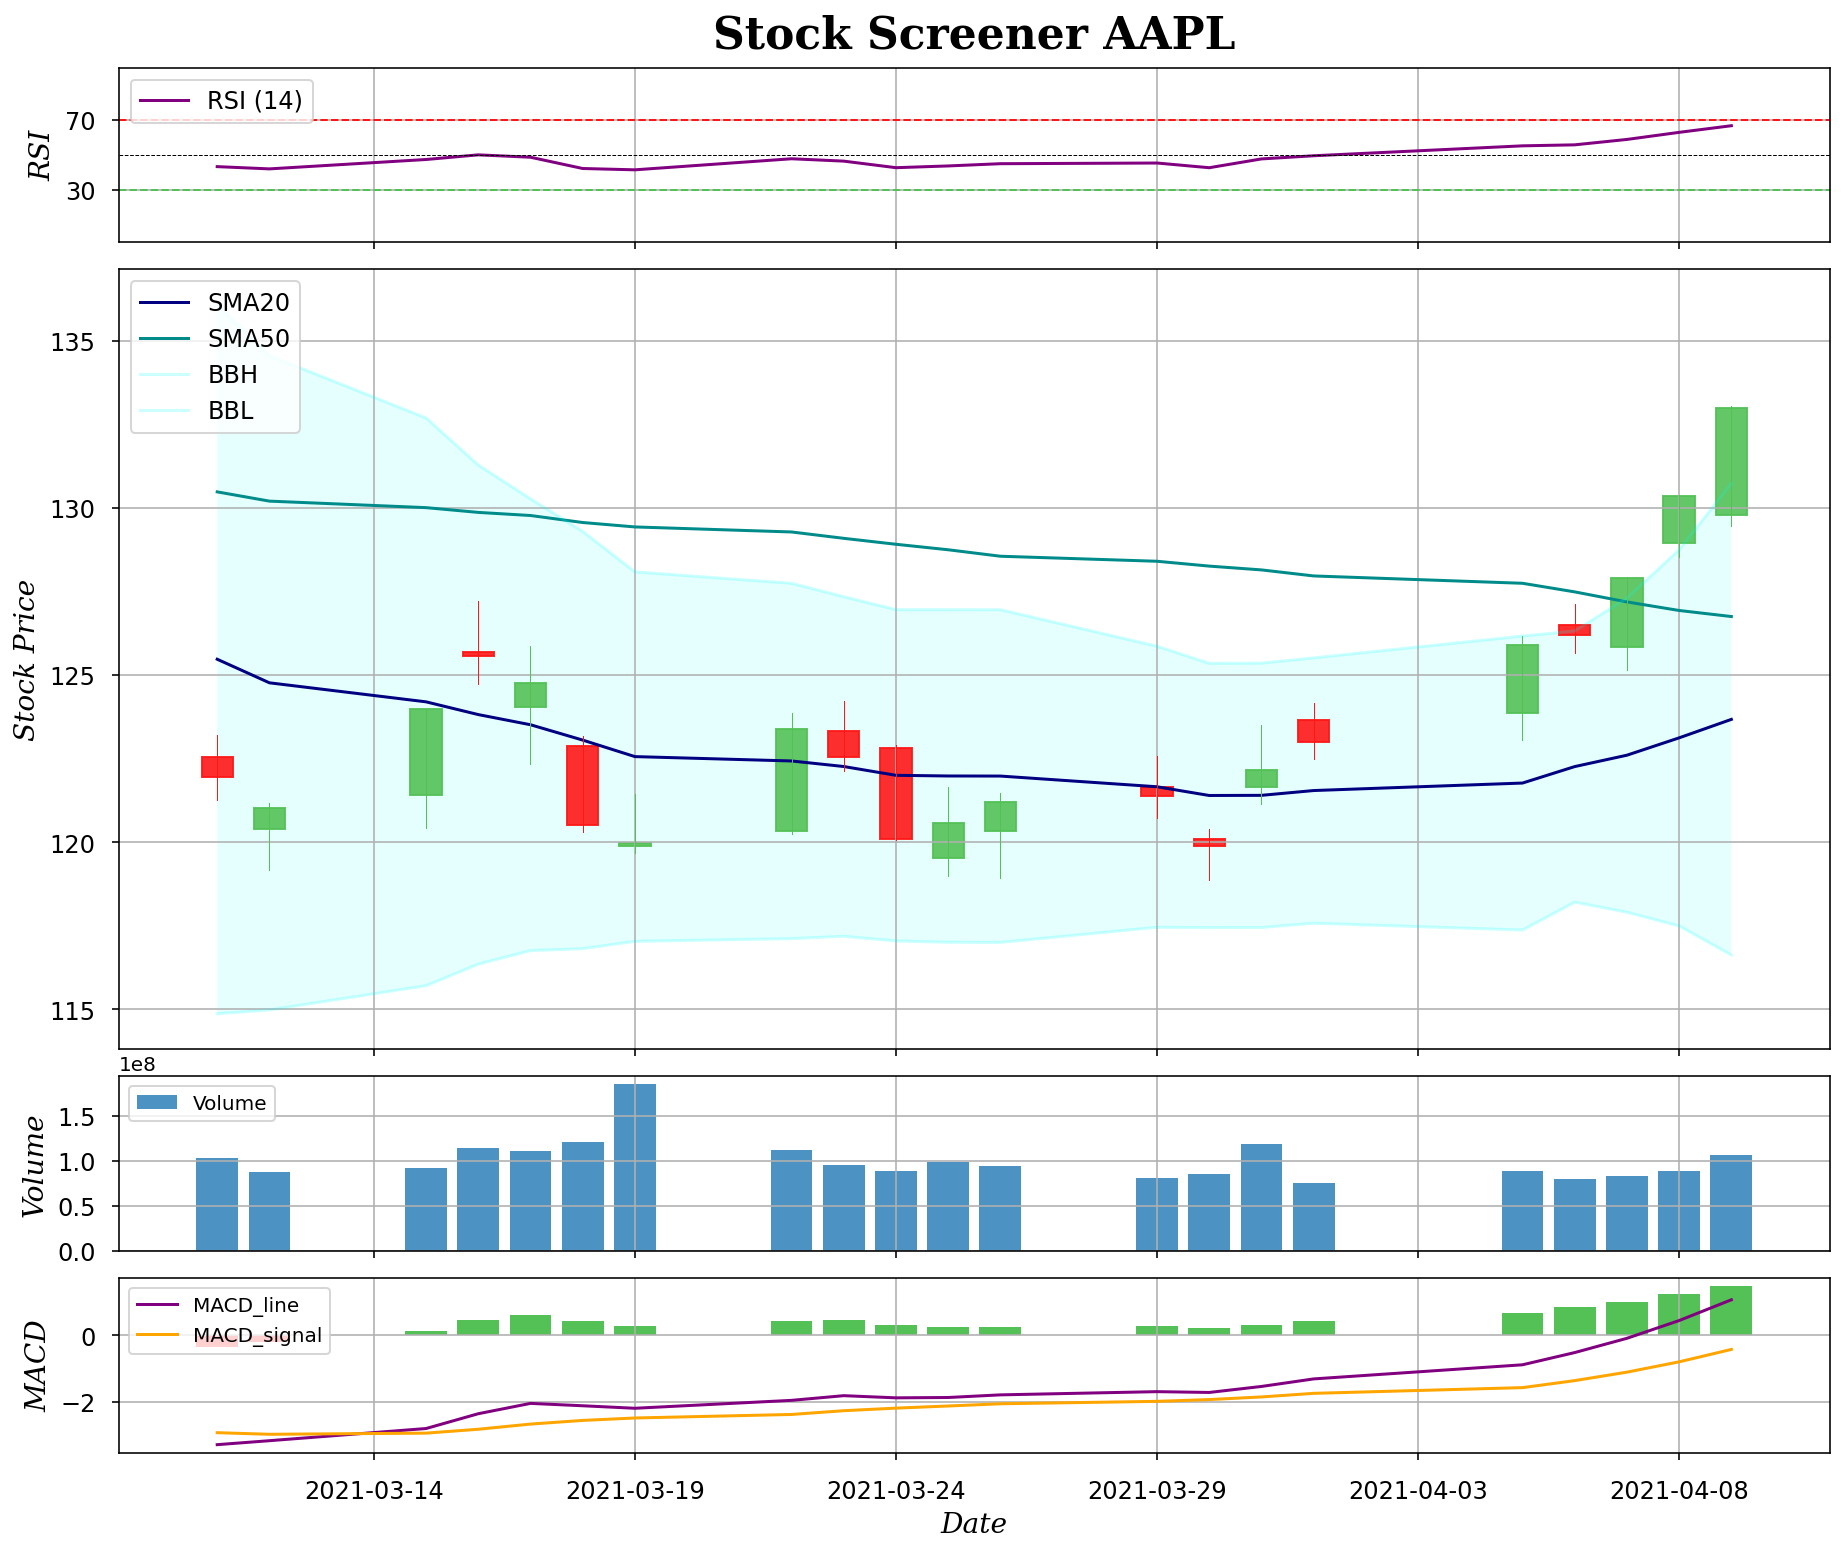

In [9]:
start = datetime.today() - timedelta(31)
end = datetime.today()

# plot_screener(prices_df, 'MSFT', '2020-12-01', '2021-12-31')
plot_screener(prices_df, ['MSFT'], start, end)

---

In [ ]:
import yfinance as yf
from matplotlib.animation import FuncAnimation

In [ ]:
start = datetime.today() - timedelta(7)
end = datetime.today()
ticker = 'MSFT'


prices_df = yf.Ticker(ticker).history(start=start, end=end, interval='1m').reset_index()
# Set the timeframe you are interested in viewing.
prices_df.columns = [column.lower() for column in prices_df.columns]
prices_df.rename(columns={'datetime': 'date'}, inplace=True)
prices_df['ticker'] = ticker

In [ ]:
fig = plt.figure(figsize=(14,12))

animation = FuncAnimation(fig, plot_screener(prices_df, ['MSFT'], start, end), interval=1000)